# Emotional Sentiment through Mouse and Keyboard Dynamics
Ryan J Meneses, 2023

## Description
chillpill is an application that collects mouse and keyboard dynamics data from a user and uses it to predict their emotional state. This notebook analyzes the data collected from the application's data collection API and trains linear model to predict the user's emotional state.

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from src.util import file

In [2]:
tracking_data = {}
for filename in os.listdir(file.TRACKING_PATH):
    if filename.endswith(".csv"):
        tracking_data[filename] = file.load_tracking_file(filename)
        print(f"Loaded {filename} with {len(tracking_data[filename])} rows.")

tracking_data["20230503-023014.csv"].head()

Loaded 20230507-155134.csv with 100000 rows.
Loaded 20230503-155648.csv with 100001 rows.
Loaded 20230503-214649.csv with 100000 rows.
Loaded 20230503-023014.csv with 100000 rows.


,id,time,x,y,scroll,press,release,feeling
0,1,1.683096e+09,0.000000,0.000000,0,0,50,1
1,2,1.683096e+09,379.273438,362.273438,0,0,0,1
2,3,1.683096e+09,381.156250,362.273438,0,0,0,1
3,4,1.683096e+09,383.039062,362.273438,0,0,0,1
4,5,1.683096e+09,385.894531,362.273438,0,0,0,1


In [3]:
tracking_data["20230503-023014.csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   time     100000 non-null  float64
 2   x        100000 non-null  float64
 3   y        100000 non-null  float64
 4   scroll   100000 non-null  int64  
 5   press    100000 non-null  int64  
 6   release  100000 non-null  int64  
 7   feeling  100000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 6.1 MB


In [4]:
tracking_data["20230503-023014.csv"].describe()

,id,time,x,y,scroll,press,release,feeling
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000
mean,50000.499960,1.683102e+09,396.336092,198.127324,0.299400,1.738710,1.763340,2.5000
std,28867.657799,3.619452e+03,380.252713,223.978622,0.457998,13.338934,13.435925,1.0247
min,1.000000,1.683096e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1.0000
25%,25000.750000,1.683100e+09,0.000000,0.000000,0.000000,0.000000,0.000000,2.0000
50%,50000.500000,1.683102e+09,352.613281,110.314453,0.000000,0.000000,0.000000,2.5000
75%,75000.250000,1.683105e+09,690.957031,369.055664,1.000000,0.000000,0.000000,3.0000
max,100000.000000,1.683106e+09,1279.996094,799.996094,1.000000,122.000000,122.000000,4.0000


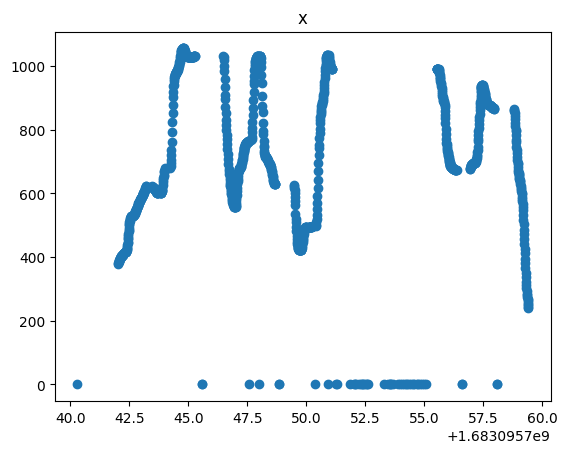

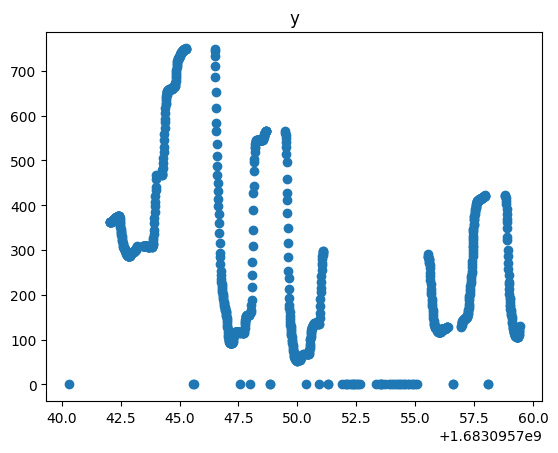

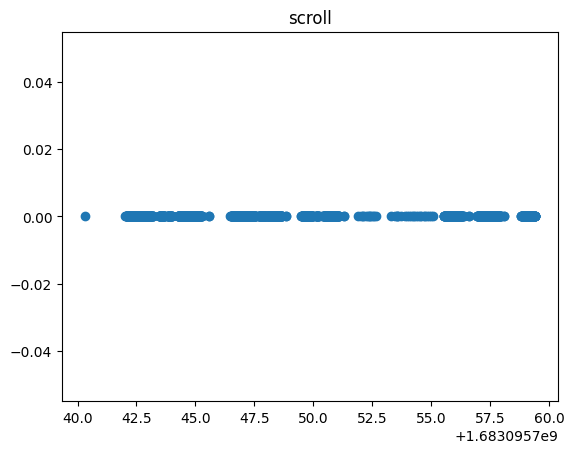

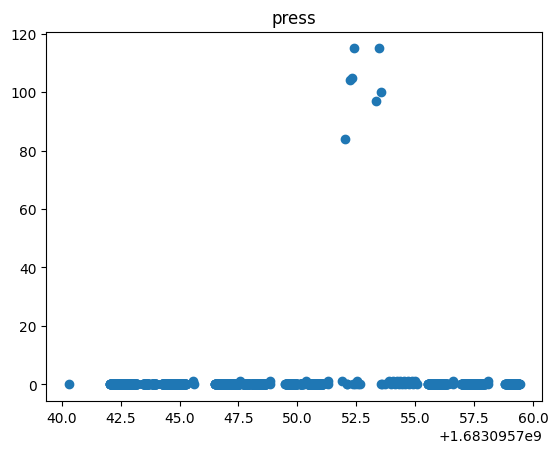

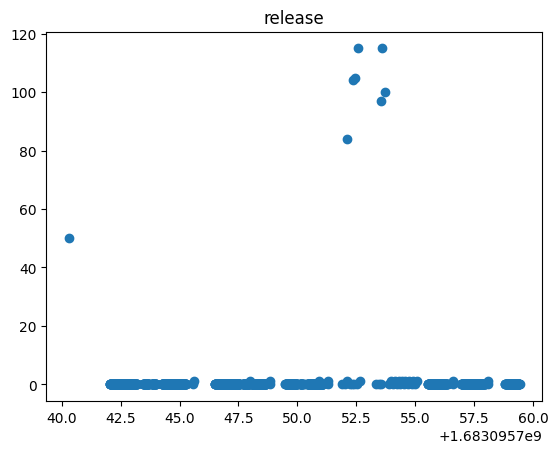

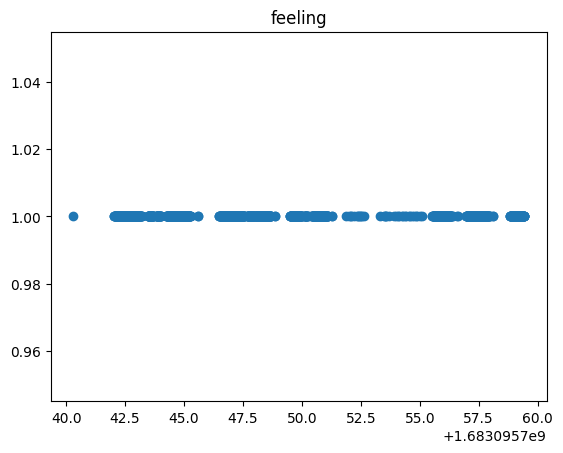

In [5]:
# make scatter plots of the data with respect to time except for the time column and id column
for column in tracking_data["20230503-023014.csv"].columns:
    if column not in ["time", "id"]:
        plt.scatter(
            tracking_data["20230503-023014.csv"]["time"][:1000],
            tracking_data["20230503-023014.csv"][column][:1000],
        )
        plt.title(column)
        plt.show()

In [ ]:
# TODO: Create a bar plot of percentage of emotions
plt.scatter(
    tracking_data["20230503-023014.csv"]["feeling"],
    tracking_data["20230503-023014.csv"]["time"],
)
plt.title("x vs y")
plt.show()

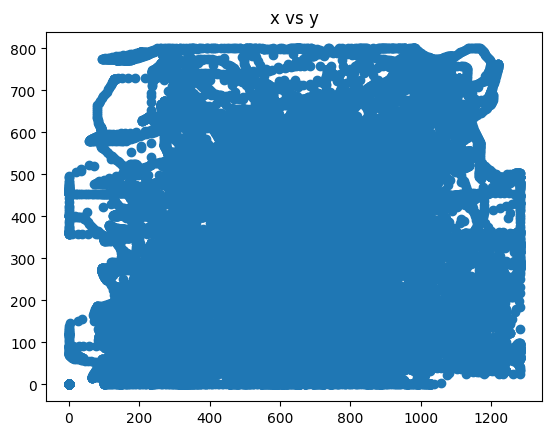

In [6]:
# plot x vs y
plt.scatter(
    tracking_data["20230503-023014.csv"]["x"], tracking_data["20230503-023014.csv"]["y"]
)
plt.title("x vs y")
plt.show()

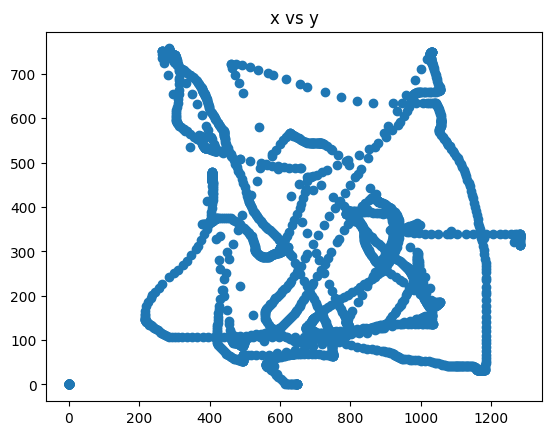

In [7]:
# plot only the first 1000 rows of x vs y
plt.scatter(
    tracking_data["20230503-023014.csv"]["x"][:2500],
    tracking_data["20230503-023014.csv"]["y"][:2500],
)
plt.title("x vs y")
plt.show()

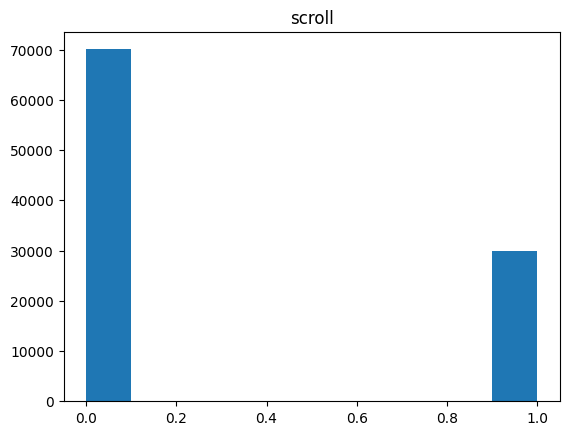

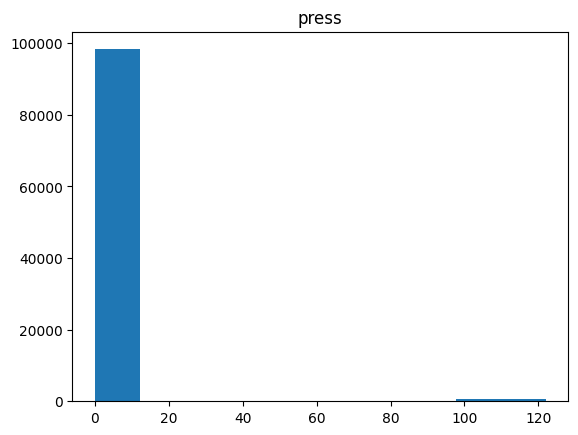

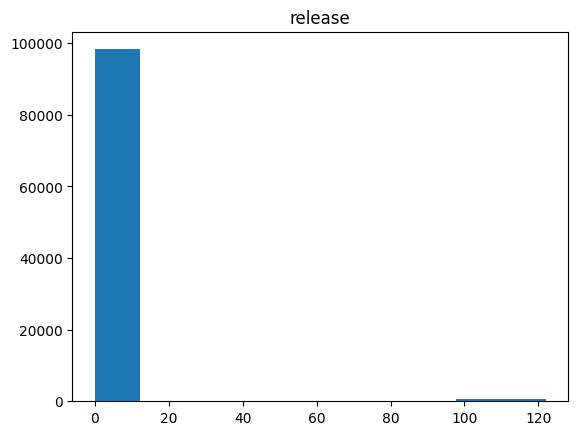

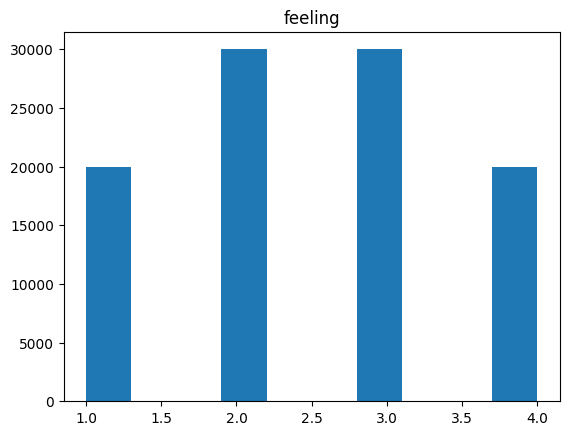

In [8]:
# plot histograms of the data except for the time, id, x, and y columns
for column in tracking_data["20230503-023014.csv"].columns:
    if column not in ["time", "id", "x", "y"]:
        plt.hist(tracking_data["20230503-023014.csv"][column])
        plt.title(column)
        plt.show()

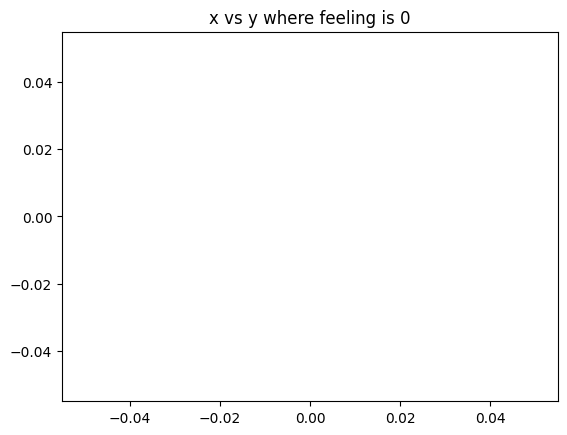

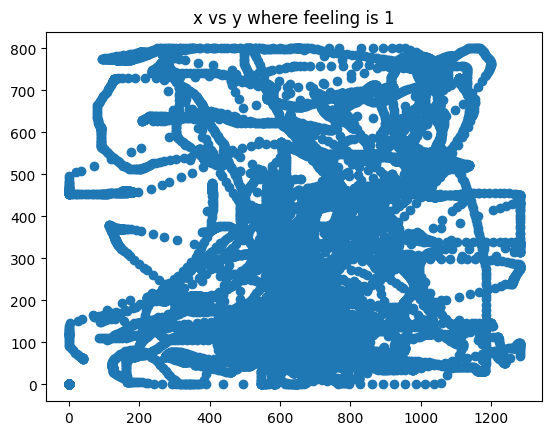

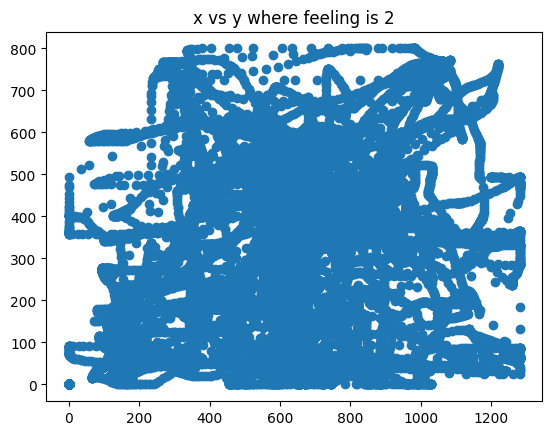

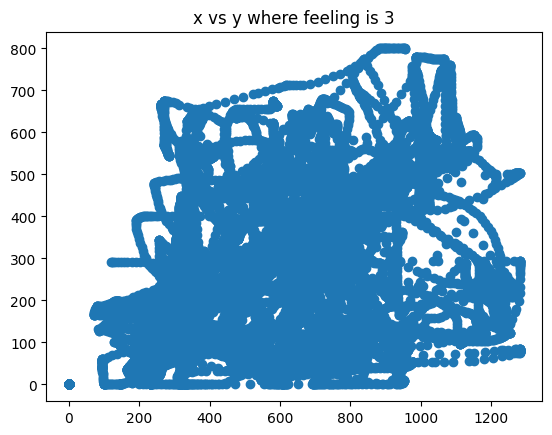

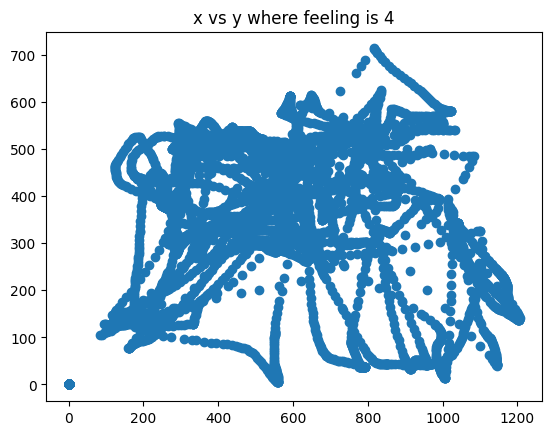

In [9]:
# plot the first 1000 x vs y where feeling is 0, 1, 2, 3, and 4
for feeling in range(5):
    plt.scatter(
        tracking_data["20230503-023014.csv"]["x"][
            tracking_data["20230503-023014.csv"]["feeling"] == feeling
        ],
        tracking_data["20230503-023014.csv"]["y"][
            tracking_data["20230503-023014.csv"]["feeling"] == feeling
        ],
    )
    plt.title(f"x vs y where feeling is {feeling}")
    plt.show()

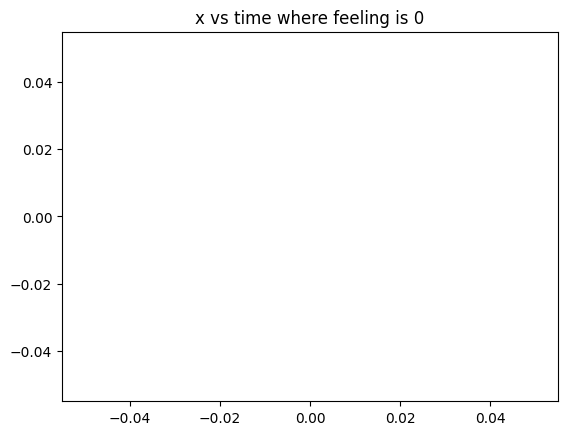

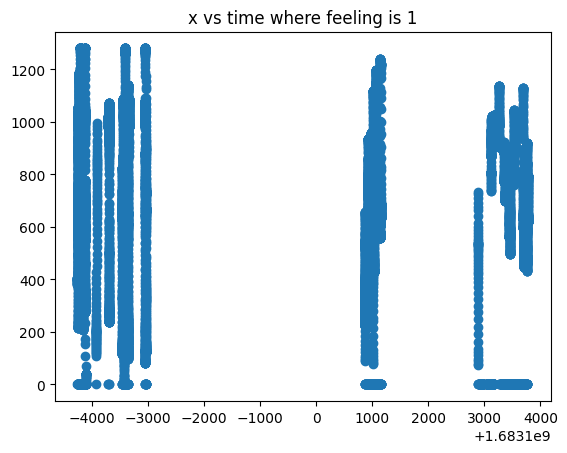

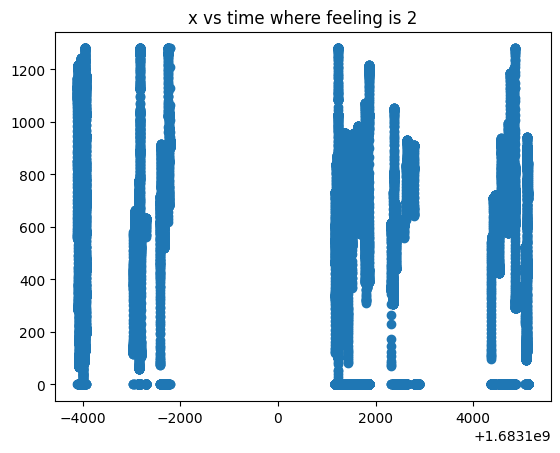

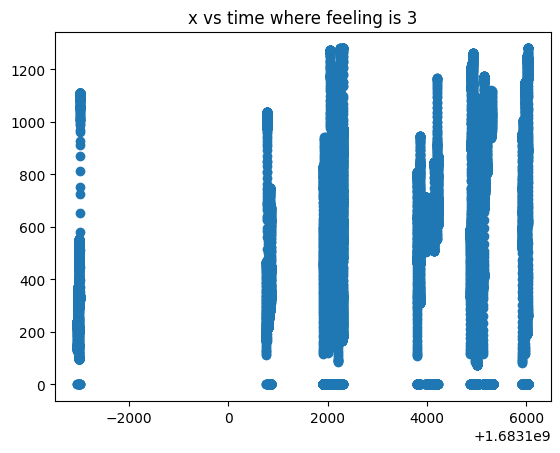

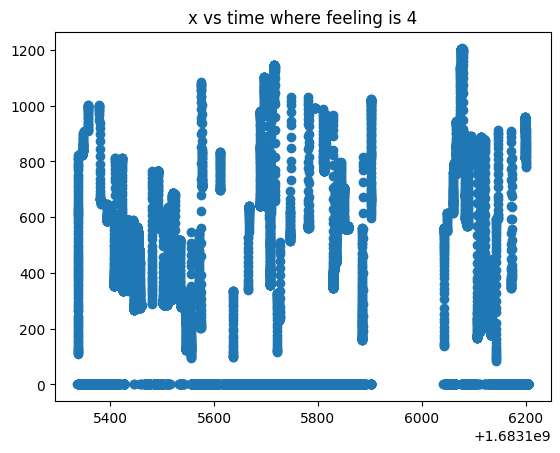

In [10]:
# plot x vs time only where feeling is 3
for feeling in range(5):
    plt.scatter(
        tracking_data["20230503-023014.csv"]["time"][
            tracking_data["20230503-023014.csv"]["feeling"] == feeling
        ],
        tracking_data["20230503-023014.csv"]["x"][
            tracking_data["20230503-023014.csv"]["feeling"] == feeling
        ],
    )
    plt.title(f"x vs time where feeling is {feeling}")
    plt.show()

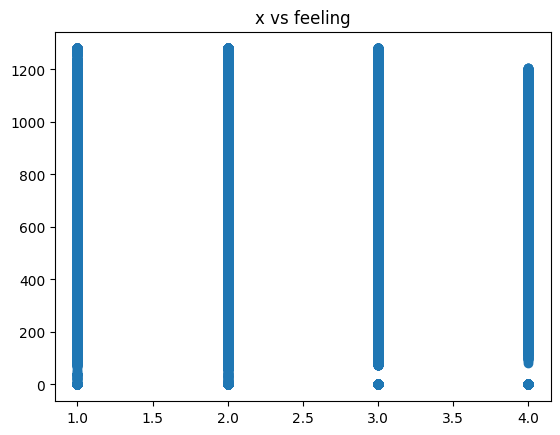

In [11]:
# plot x vs feeling
plt.scatter(
    tracking_data["20230503-023014.csv"]["feeling"],
    tracking_data["20230503-023014.csv"]["x"],
)
plt.title("x vs feeling")
plt.show()